In [54]:
# ! pip install openml

### Libraries

In [32]:
import openml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from tqdm import tqdm

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Models
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc  
from scipy.stats import kendalltau

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from RandomSearch.RandomSearchWithMetrics import RandomSearchWithMetrics


In [33]:
# dataset 1 
dataset = openml.datasets.get_dataset(833)

X1, y1, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# dataset 2
dataset = openml.datasets.get_dataset(44157)

X2, y2, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# dataset 3
dataset = openml.datasets.get_dataset(1120)

X3, y3, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# dataset 4
dataset = openml.datasets.get_dataset(45553)

X4, y4, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)



### Deleting correlated columns, creating pipeline

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_9952/874860428.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix_2 = X2.corr()
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_9952/874860428.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix_4 = X4.corr()


Dataset 1 cor matrix printed
Dataset 2 cor matrix printed
Dataset 3 cor matrix printed
Dataset 4 cor matrix printed


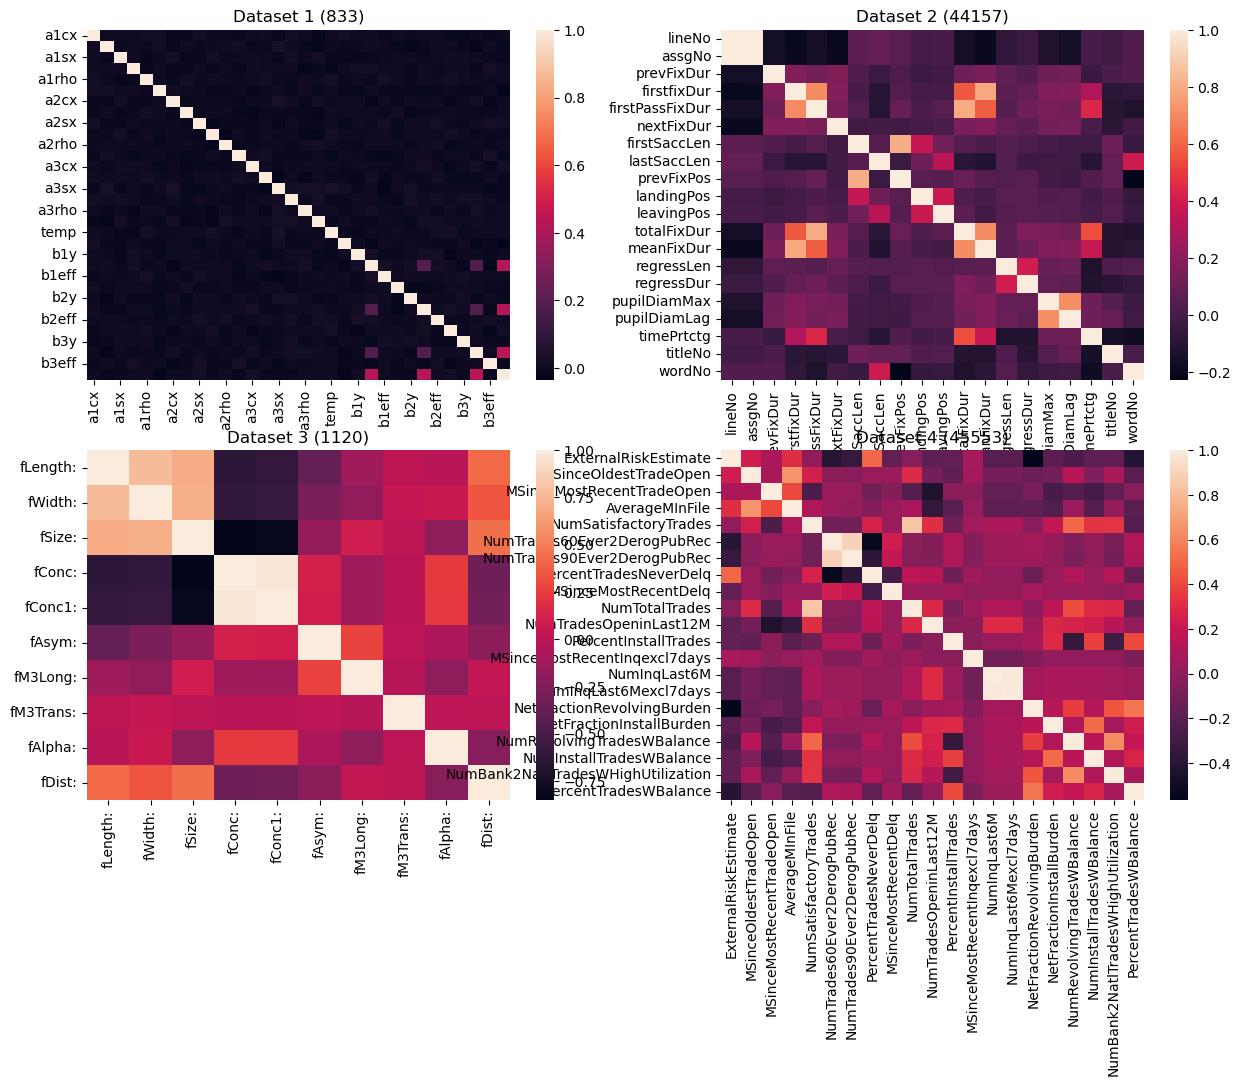

In [34]:
# correlation matrix
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

cor_matrix_1 = X1.corr()
cor_matrix_2 = X2.corr()
cor_matrix_3 = X3.corr()
cor_matrix_4 = X4.corr()

sns.heatmap(cor_matrix_1, ax = axes[0,0])
axes[0,0].set_title("Dataset 1 (833)")
print("Dataset 1 cor matrix printed")

sns.heatmap(cor_matrix_2, ax = axes[0,1])
axes[0,1].set_title("Dataset 2 (44157)")
print("Dataset 2 cor matrix printed")

sns.heatmap(cor_matrix_3,  ax = axes[1,0])
axes[1,0].set_title("Dataset 3 (1120)")
print("Dataset 3 cor matrix printed")

sns.heatmap(cor_matrix_4, ax = axes[1,1])
axes[1,1].set_title("Dataset 4 (45553)")
print("Dataset 4 cor matrix printed")

Text(0.5, 1.0, 'Dataset 4 (45553)')

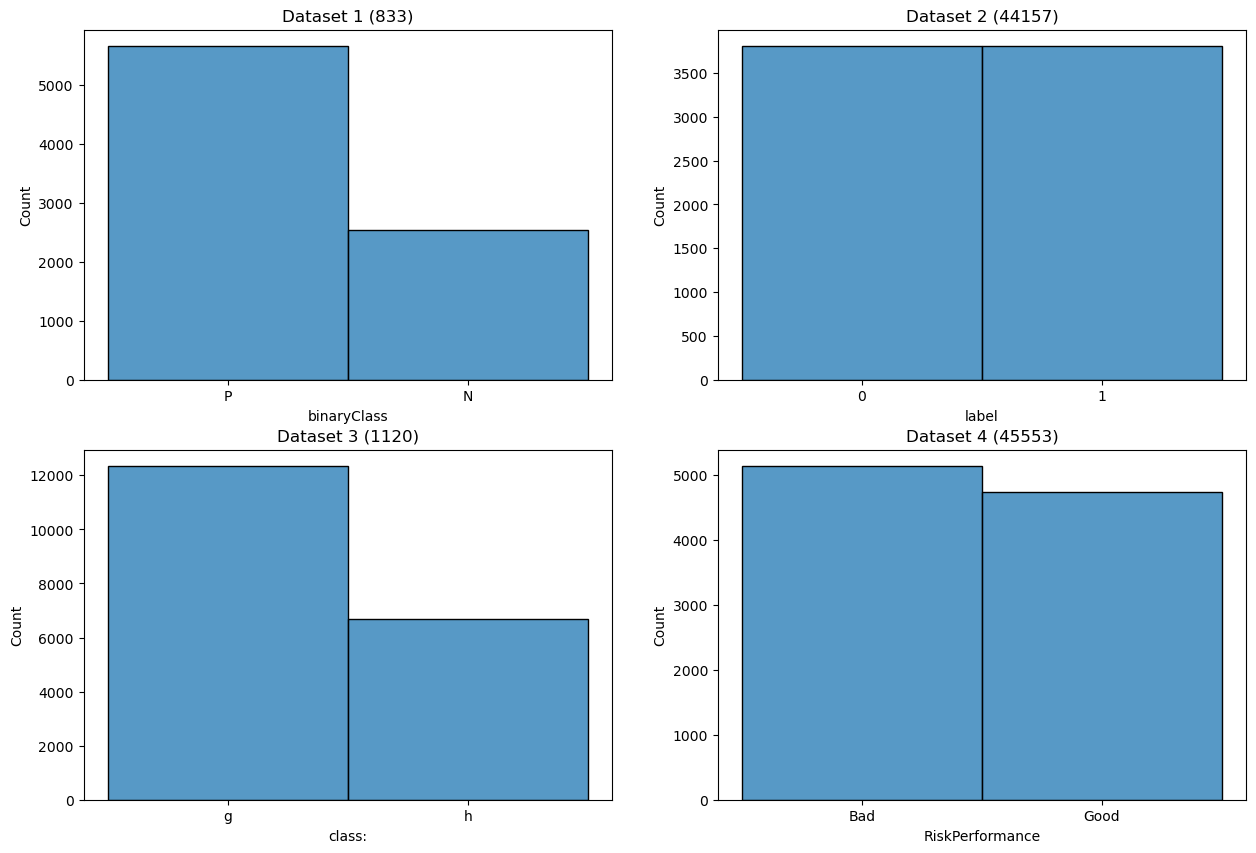

In [35]:
# distribution on targets
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

sns.histplot(y1, ax=axes[0,0])
axes[0,0].set_title("Dataset 1 (833)")

sns.histplot(y2, ax=axes[0,1])
axes[0,1].set_title("Dataset 2 (44157)")

sns.histplot(y3, ax=axes[1,0])
axes[1,0].set_title("Dataset 3 (1120)")

sns.histplot(y4, ax=axes[1,1])
axes[1,1].set_title("Dataset 4 (45553)")

In [36]:
# change the target to (0,1) numeric
y1 = y1.replace({'N': 1, 'P': 0}).astype(int)
y2 = y2.replace({'0': 1, '1': 0}).astype(int)
y3 = y3.replace({'g': 0, 'h': 1}).astype(int)
y4 = y4.replace({'Bad': 0, 'Good': 1}).astype(int)

In [37]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

col_trans = ColumnTransformer([
    ('num_pipeline', num_pipeline, make_column_selector(dtype_include = np.number)),
    ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include = np.object_))
])

In [38]:
def are_correlated_removed(X, max_corr):
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > max_corr and i!=j:
                return corr_matrix.columns[i]
    return None 

class RemoveCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, max_correlation=0.75):
        self.max_correlation = max_correlation
        self.correlated_columns_ = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            
        res = are_correlated_removed(X, self.max_correlation)
        while res is not None:
            self.correlated_columns_.append(res)
            X = X.drop(columns=[res])
            res = are_correlated_removed(X, self.max_correlation)
        return X


/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_9952/2215397314.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X.corr()
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_9952/2215397314.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X.corr()
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_9952/2215397314.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X.corr()
/var/folders/y9/p941jysn0ddb8zk

Text(0.5, 1.0, 'Dataset 4 (45553)')

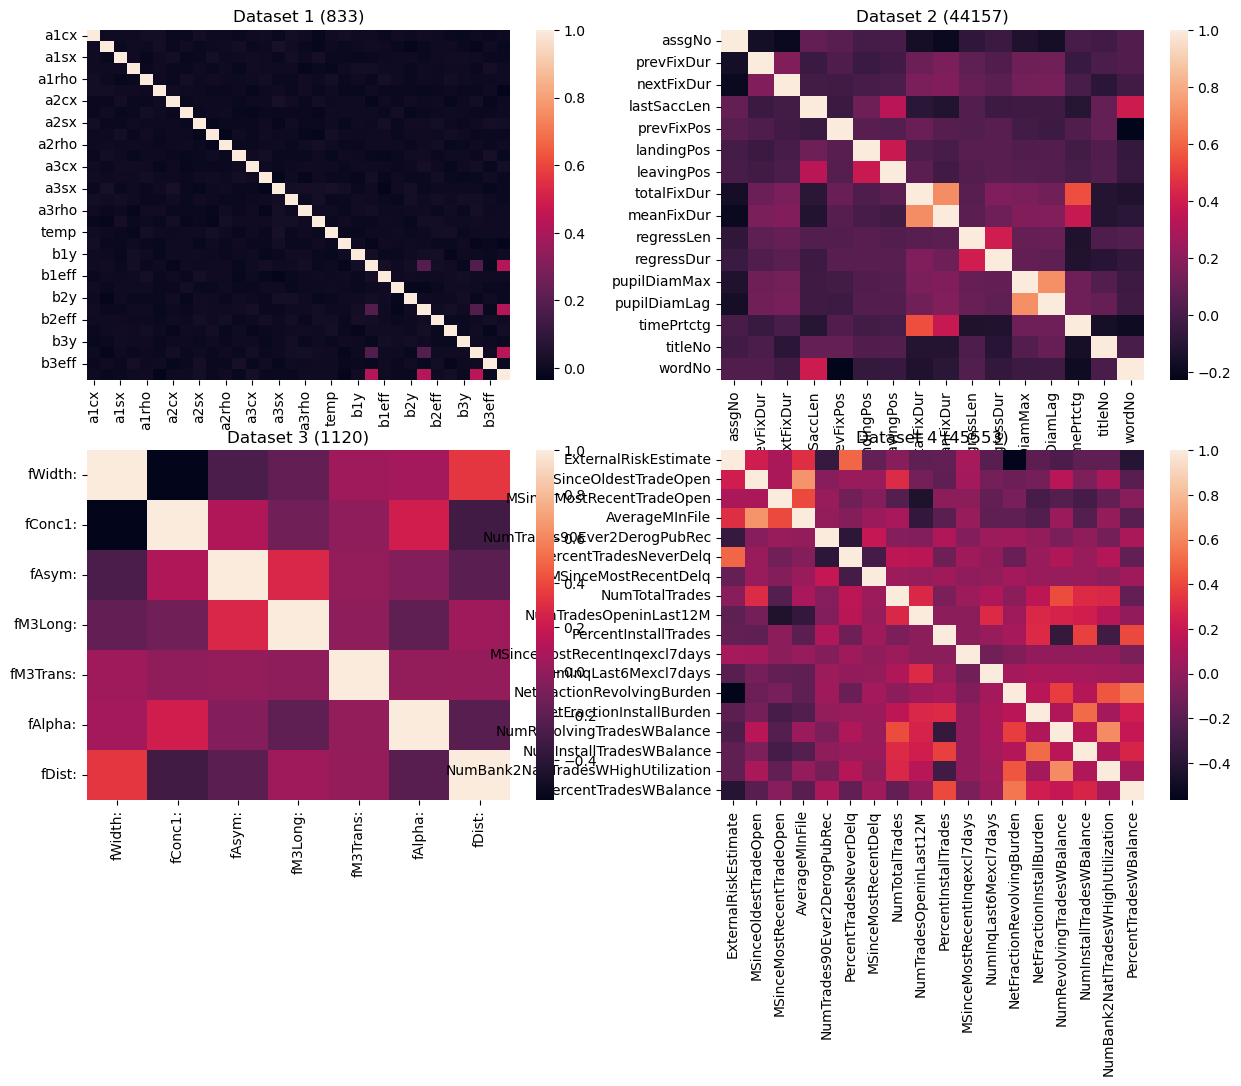

In [39]:
# we should delete correlated features before applying the pipeline, because a situation, 
# when in train set 2 features are correlated, but in test set they are not, can happen (max_correlation = 0.75)
X1 = RemoveCorrelatedFeatures().fit_transform(X1, 0.75)
X2 = RemoveCorrelatedFeatures().fit_transform(X2, 0.75)
X3 = RemoveCorrelatedFeatures().fit_transform(X3, 0.75)
X4 = RemoveCorrelatedFeatures().fit_transform(X4, 0.75)

# correlation matrix
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

cor_matrix_1 = X1.corr()
cor_matrix_2 = X2.corr()
cor_matrix_3 = X3.corr()
cor_matrix_4 = X4.corr()

sns.heatmap(cor_matrix_1, ax = axes[0,0])
axes[0,0].set_title("Dataset 1 (833)")

sns.heatmap(cor_matrix_2, ax = axes[0,1])
axes[0,1].set_title("Dataset 2 (44157)")

sns.heatmap(cor_matrix_3,  ax = axes[1,0])
axes[1,0].set_title("Dataset 3 (1120)")

sns.heatmap(cor_matrix_4, ax = axes[1,1])
axes[1,1].set_title("Dataset 4 (45553)")


### Extra Trees Classifier + RandomSearch

In [40]:
params_extra_trees = {
    'model__n_estimators': list(set([int(x) for x in 2*np.logspace(start=0, stop=3, num=50)])), # due to the resourse limit we limit the number of trees in logspace
    'model__max_depth': [None] + [int(x) for x in np.linspace(start = 1, stop = 30, num = 15)],
    'model__min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 60, num = 59)],
    'model__min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 60, num = 60)],
    'model__min_weight_fraction_leaf':[x for x in np.linspace(start = 0, stop = 0.5, num = 20)], # using linspace, because float values all the time will be different
    'model__max_leaf_nodes': [None] + [int(x) for x in np.linspace(start = 2, stop = 60, num = 58)],
    'model__max_features': ["sqrt", "log2", None] + list(set(np.linspace(start=0.1, stop=1.0, num=20))),    
    'model__criterion': ['gini', 'entropy']
}

default_extra_trees = {}

final_preprocessing_pipeline = Pipeline(steps=[
    ('preprocessing', col_trans),
    ('model', ExtraTreesClassifier(random_state=42))
])

In [45]:
# dataset 1
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X1,
    y=y1,
    cv=5,
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_1.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_1.csv')

In [41]:
# dataset 1 default
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    default_extra_trees,
    n_iter=1,
    X=X1,
    y=y1,
    cv=5, 
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_1_default.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_1_default.csv')

In [46]:
# dataset 2
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X2,
    y=y2,
    cv=5, 
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_2.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_2.csv')

In [42]:
# dataset 2 default
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    default_extra_trees,
    n_iter=1,
    X=X2,
    y=y2,
    cv=5, 
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_2_default.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_2_default.csv')

In [48]:
# dataset 3
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X3,
    y=y3,
    cv=5,
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_3.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_3.csv')

In [43]:
# dataset 3 default
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    default_extra_trees,
    n_iter=1,
    X=X3,
    y=y3,
    cv=5, 
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_3_default.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_3_default.csv')

In [50]:
# dataset 4
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X4,
    y=y4,
    cv=5,
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_4.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_4.csv')

In [44]:
# dataset 4 default 
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    default_extra_trees,
    n_iter=1,
    X=X4,
    y=y4,
    cv=5, 
    path = 'RandomSearch/ExtraTreesClassifier/extra_trees_4_default.csv'
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_4_default.csv')

### Support Vector Machine + RandomSearch

In [47]:
params_svm = {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__C': list(np.power(2, np.arange(-10, 10, 1, dtype=float))),
    'model__gamma': list(np.power(2, np.arange(-10, 10, 1, dtype=float))),
    'model__degree': [2, 3, 4, 5],
}

final_preprocessing_pipeline = Pipeline(steps=[
    ('preprocessing', col_trans),
    ('model', SVC(probability=True, max_iter=300, random_state=42))
])

In [49]:
params_svm_default = {}

import warnings

# a warning is raised when the model was terminated before the fit was completed
warnings.filterwarnings("ignore", category=UserWarning)

# dataset 1 default

random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm_default,
    n_iter=1,
    X=X1,
    y=y1,
    cv=5, 
    path = 'RandomSearch/SupportVectorMachine/svm_1_default.csv'
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_1_default.csv')

In [42]:
# dataset 1
import warnings

# a warning is raised when the model was terminated before the fit was completed, because of max_iter=300
warnings.filterwarnings("ignore", category=UserWarning)
random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm,
    n_iter=400,
    X=X1,
    y=y1,
    cv=5
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_1.csv')

{'model__kernel': 'linear', 'model__C': 512.0, 'model__gamma': 0.25, 'model__degree': 5}
{'model__kernel': 'rbf', 'model__C': 4.0, 'model__gamma': 64.0, 'model__degree': 2}
{'model__kernel': 'rbf', 'model__C': 1.0, 'model__gamma': 8.0, 'model__degree': 4}
{'model__kernel': 'poly', 'model__C': 32.0, 'model__gamma': 0.03125, 'model__degree': 5}
{'model__kernel': 'sigmoid', 'model__C': 0.001953125, 'model__gamma': 0.0009765625, 'model__degree': 4}
{'model__kernel': 'rbf', 'model__C': 4.0, 'model__gamma': 64.0, 'model__degree': 5}
{'model__kernel': 'sigmoid', 'model__C': 32.0, 'model__gamma': 8.0, 'model__degree': 2}
{'model__kernel': 'rbf', 'model__C': 2.0, 'model__gamma': 0.03125, 'model__degree': 2}
{'model__kernel': 'linear', 'model__C': 0.5, 'model__gamma': 16.0, 'model__degree': 3}
{'model__kernel': 'linear', 'model__C': 0.0078125, 'model__gamma': 128.0, 'model__degree': 2}
{'model__kernel': 'linear', 'model__C': 128.0, 'model__gamma': 16.0, 'model__degree': 4}
{'model__kernel': 'rbf

In [50]:
# dataset 2 default

random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm_default,
    n_iter=1,
    X=X2,
    y=y2,
    cv=5, 
    path = 'RandomSearch/SupportVectorMachine/svm_2_default.csv'
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_2_default.csv')

In [43]:
# dataset 2
random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm,
    n_iter=400,
    X=X2,
    y=y2,
    cv=5
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_2.csv')

{'model__kernel': 'linear', 'model__C': 16.0, 'model__gamma': 1.0, 'model__degree': 4}
{'model__kernel': 'rbf', 'model__C': 1.0, 'model__gamma': 0.25, 'model__degree': 2}
{'model__kernel': 'rbf', 'model__C': 128.0, 'model__gamma': 0.001953125, 'model__degree': 5}
{'model__kernel': 'rbf', 'model__C': 32.0, 'model__gamma': 16.0, 'model__degree': 2}
{'model__kernel': 'poly', 'model__C': 1.0, 'model__gamma': 0.0078125, 'model__degree': 5}
{'model__kernel': 'linear', 'model__C': 0.0009765625, 'model__gamma': 32.0, 'model__degree': 3}
{'model__kernel': 'sigmoid', 'model__C': 8.0, 'model__gamma': 0.0009765625, 'model__degree': 5}
{'model__kernel': 'rbf', 'model__C': 8.0, 'model__gamma': 0.03125, 'model__degree': 4}
{'model__kernel': 'linear', 'model__C': 0.5, 'model__gamma': 0.5, 'model__degree': 3}
{'model__kernel': 'poly', 'model__C': 128.0, 'model__gamma': 0.015625, 'model__degree': 5}
{'model__kernel': 'rbf', 'model__C': 8.0, 'model__gamma': 0.00390625, 'model__degree': 5}
{'model__kernel

In [44]:
# dataset 3
random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm,
    n_iter=400,
    X=X3,
    y=y3,
    cv=5
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_3.csv')

{'model__kernel': 'linear', 'model__C': 128.0, 'model__gamma': 0.03125, 'model__degree': 5}
{'model__kernel': 'linear', 'model__C': 0.001953125, 'model__gamma': 0.0078125, 'model__degree': 5}
{'model__kernel': 'sigmoid', 'model__C': 512.0, 'model__gamma': 2.0, 'model__degree': 3}
{'model__kernel': 'rbf', 'model__C': 512.0, 'model__gamma': 0.0009765625, 'model__degree': 3}
{'model__kernel': 'rbf', 'model__C': 0.0078125, 'model__gamma': 32.0, 'model__degree': 3}
{'model__kernel': 'poly', 'model__C': 0.0078125, 'model__gamma': 0.0009765625, 'model__degree': 4}
{'model__kernel': 'poly', 'model__C': 0.00390625, 'model__gamma': 256.0, 'model__degree': 4}
{'model__kernel': 'sigmoid', 'model__C': 0.0078125, 'model__gamma': 0.03125, 'model__degree': 4}
{'model__kernel': 'poly', 'model__C': 0.03125, 'model__gamma': 8.0, 'model__degree': 3}
{'model__kernel': 'poly', 'model__C': 0.0009765625, 'model__gamma': 0.015625, 'model__degree': 4}
{'model__kernel': 'linear', 'model__C': 1.0, 'model__gamma':

In [52]:
# dataset 3 default
random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm_default,
    n_iter=1,
    X=X3,
    y=y3,
    cv=5, 
    path = 'RandomSearch/SupportVectorMachine/svm_3_default.csv'
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_3_default.csv')

In [45]:
# dataset 4
random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm,
    n_iter=400,
    X=X4,
    y=y4,
    cv=5, 
    path = 'RandomSearch/SupportVectorMachine/svm_4.csv'
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_4.csv')

{'model__kernel': 'poly', 'model__C': 64.0, 'model__gamma': 0.0078125, 'model__degree': 2}
{'model__kernel': 'linear', 'model__C': 0.00390625, 'model__gamma': 4.0, 'model__degree': 2}
{'model__kernel': 'sigmoid', 'model__C': 128.0, 'model__gamma': 32.0, 'model__degree': 5}
{'model__kernel': 'sigmoid', 'model__C': 0.00390625, 'model__gamma': 2.0, 'model__degree': 5}
{'model__kernel': 'linear', 'model__C': 256.0, 'model__gamma': 0.00390625, 'model__degree': 3}
{'model__kernel': 'poly', 'model__C': 32.0, 'model__gamma': 512.0, 'model__degree': 3}
{'model__kernel': 'linear', 'model__C': 4.0, 'model__gamma': 64.0, 'model__degree': 4}
{'model__kernel': 'sigmoid', 'model__C': 16.0, 'model__gamma': 2.0, 'model__degree': 2}
{'model__kernel': 'rbf', 'model__C': 16.0, 'model__gamma': 1.0, 'model__degree': 3}
{'model__kernel': 'poly', 'model__C': 512.0, 'model__gamma': 2.0, 'model__degree': 4}
{'model__kernel': 'linear', 'model__C': 0.0009765625, 'model__gamma': 0.00390625, 'model__degree': 5}
{'m

In [53]:
# dataset 4 default
random_search_svm = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_svm_default,
    n_iter=1,
    X=X4,
    y=y4,
    cv=5, 
    path = 'RandomSearch/SupportVectorMachine/svm_4_default.csv'
)

random_search_svm.fit_and_evaluate()
random_search_svm.save_results('RandomSearch/SupportVectorMachine/svm_4_default.csv')